# Lab 03: Cây quyết định & Hồi quy tuyến tính

- Họ tên: Nguyễn Đình Hoàng Quân
- MSSV:21120535

<font color='red'>**LƯU Ý:**</font>

- Bài làm của sinh viên phải do chính bản thân sinh viên tự làm, có thể trao đổi và tham khảo ý tưởng nhưng không được sao chép (một phần hoặc toàn bộ) code hoặc lời giải từ bất cứ người nào khác. Nếu vi phạm sẽ bị <font color='red'>0đ</font> bài tập này.
- Các bạn có thể tạo thêm các cell trong quá trình code, tuy nhiên các bạn vui lòng <font color='red'>không xóa các cell code mặc định và các cell test case</font> (vì có thể ảnh hưởng đến kết quả khi chấm bài).
- Các test case được đưa ra chỉ nhằm mục đích giúp các bạn test code của mình, <font color='red'>**việc pass các test case này không đồng nghĩa với việc lời giải của các bạn sẽ đạt điểm tối đa**</font>. 

**Cách làm bài**


Bạn sẽ làm trực tiếp trên file notebook này; trong file, từ `TODO` để cho biết những phần mà bạn cần phải làm.

**Cách nộp bài**

Khi chấm bài, đầu tiên mình sẽ chọn `Kernel` - `Restart Kernel & Run All Cells`, để restart và chạy tất cả các cell trong notebook của các bạn; do đó, trước khi nộp bài, các bạn nên chạy thử `Kernel` - `Restart Kernel & Run All Cells` để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, các bạn tạo thư mục nộp bài theo cấu trúc sau:

- Thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - File `MSSV.ipynb` (Đổi tên file notebook này theo MSSV của bạn)

Cuối cùng, các bạn nén thư mục `MSSV` này lại và nộp ở link trên moodle. **Đuôi của file nén phải là .zip (chứ không được .rar hay gì khác).**

<font color=red>Các bạn lưu ý tuân thủ chính xác qui định nộp bài ở trên.</font>

**Nội dung bài tập**

Bài tập 3 là bài tập cá nhân. Trong bài này, bạn sẽ cài đặt thuật toán học máy: 
1. Cây quyết định (Decision tree)
2. Hồi quy tuyến tính (Linear Regression)

### Tải những thư viện cần thiết

In [254]:

import os
from zlib import adler32
from typing import Tuple, List
import requests
import shutil
import random

import scipy
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

In [255]:
# Init seed
seed = 2024
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Tải tập dữ liệu Iris

In [256]:
def download_dataset(save_path: str = "data"):
    """Function for downloading Iris dataset

    After calling this function, the dataset will automated download, unzip and remove the original zip file.
    
    The structure will organized like this: 
    data
    ├── bezdekIris.data
    ├── Index
    ├── iris.data
    └── iris.names
    
    Args:
        save_path (str, optional): Path to save directory for Iris dataset. Defaults to "data".
    """
    # Setup directory
    data_dir = os.path.join(
        os.getcwd(), save_path
    )  # Join paths to get the data directory path

    # Create the directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
    else:
        # If exists, removes it :)
        shutil.rmtree(data_dir)
        os.makedirs(data_dir, exist_ok=True)

    # Define URL and file paths
    iris_url = "https://archive.ics.uci.edu/static/public/53/iris.zip"
    iris_zip_path = os.path.join(data_dir, "iris.zip")

    # Download the iris dataset ZIP file
    with requests.get(iris_url, stream=True) as r:
        with open(iris_zip_path, "wb") as f:
            shutil.copyfileobj(r.raw, f)

    # Extract the ZIP file
    shutil.unpack_archive(iris_zip_path, data_dir)

    # Remove the ZIP file after extraction
    os.remove(iris_zip_path)
    
# Download Iris and mpg dataset by calling `download_dataset` function
download_dataset()

### Đọc tập dữ liệu Iris

In [257]:
def iris_dataloader(data_path: str = "data/iris.data") -> Tuple[np.ndarray, np.ndarray]:
    """Function for loading Iris dataset :)

    Args:
        data_path (str, optional): Path to Iris dataset. Defaults to "data/iris.data".

    Returns:
        Tuple[np.ndarray, np.ndarray]: return two numpy's array named `features` and `classes`, respectively.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    sepal_length = []
    sepal_width = []
    petal_length = []
    petal_width = []
    classes = []

    # Classes mapping
    class_mapping = {"Iris-setosa": 0,
                     "Iris-versicolor": 1, "Iris-virginica": 2}

    # Read data from file
    with open(data_path, "r") as file:
        # Read data each line
        for line in file:
            line = line.strip()  # Remove newline character and leading/trailing spaces
            if line:  # Check if line is not empty
                parts = line.split(",")
                sepal_length.append(float(parts[0]))
                sepal_width.append(float(parts[1]))
                petal_length.append(float(parts[2]))
                petal_width.append(float(parts[3]))
                classes.append(class_mapping[parts[4]])

    # Concatenate features
    features = np.array(
        [sepal_length, sepal_width, petal_length, petal_width]).T

    # Convert classes to numpy array
    classes = np.array(classes)

    return features, classes


# Thực hiện tải dữ liệu
features, classes = iris_dataloader()
features.shape, classes.shape

((150, 4), (150,))

In [258]:
# TEST
assert (
    adler32(str(features[0][:5] + features[1][:5] + features[2][:5]).encode())
    == 750060552
)

### Phân chia tập train-valid-test

In [259]:
def train_test_split(
    X: np.ndarray, y: np.ndarray, test_ratio=0.33
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Function for proceduring train, and test sets.

    Args:
        X (np.ndarray): input features.
        y (np.ndarray): input labels.
        test_ratio (float, optional): ratio size for test sets. Defaults to 0.33.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: features, label for train, test respectively. 
        They are represented as numpy array.
    """
    n = X.shape[0]
    idx = np.random.permutation(n)  # Shuffle indices
    train_size = int((1 - test_ratio) * n)

    # Split indices for training and test sets
    train_idx = idx[:train_size]
    test_idx = idx[train_size:]

    # Index into X and y to create training and test sets
    X_train = X[train_idx, :]
    X_test = X[test_idx, :]

    y_train = y[train_idx]
    y_test = y[test_idx]

    return (
        X_train,
        X_test,
        y_train,
        y_test,
    )


# Phân chia tập train, test.
X_train, X_test, y_train, y_test = train_test_split(features, classes)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 4), (50, 4), (100,), (50,))

In [260]:
# TEST
SP = X_train.shape + X_test.shape + y_train.shape + y_test.shape
assert adler32(str(SP).encode()) == 867828770

## Cây quyết định

### Độ lợi thông tin

Thông tin kỳ vọng (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

Hàm entropy đạt giá trị nhỏ nhất nếu có một giá trị $p_i=1$, đạt giá trị lớn nhất nếu tất cả các $p_i$ bằng nhau. Những tính chất này của hàm entropy khiến nó được sử dụng trong việc đo độ hỗn loạn của một phép phân chia của ID3.

In [261]:
def entropy(counts: List, n_samples: int) -> float:
    """Function for calculating entropy

    Args:
        counts (list): list number of samples in each class.
        n_samples (int): number of data samples.

    Return:
        entropy (float).
    """
    # YOUR CODE HERE
    entropy_val = 0
    for count in counts:
        if count == 0:
            continue
        p = count / n_samples 
        entropy_val -= p * np.log2(p)
    # raise NotImplementedError()
    return entropy_val

In [262]:
def entropy_of_one_division(division: np.ndarray) -> Tuple[float, int]:
    """Function for calculating entropy of a divided group of data.

    Please note that data may have multiple classes.

    Args:
        division (np.ndarray): input divided group of data.

    Returns:
        Tuple[float, int]: entropy of a divided group of data.
    """
    n_samples = len(division)
    n_classes = set(division)

    counts = []
    # count samples in each class then store it to list counts
    # YOUR CODE HERE
    for c in n_classes:
        counts.append(np.sum(division == c))
    return (entropy(counts, n_samples), n_samples)
    # raise NotImplementedError()



In [263]:
def get_entropy(y_predict: np.ndarray, y: np.ndarray):
    """Get entropy for a split.

    Args:
        y_predict (np.ndarray): the split decision by cutoff, True/Fasle.
        y (np.ndarray): grouth truth.

    Returns:
        s (float): entropy of input split, as real-number represented with float type.
    """
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(
        y[y_predict]
    )  # left hand side entropy
    
    entropy_false, n_false = entropy_of_one_division(
        y[~y_predict]
    )  # right hand side entropy
    # overall entropy
    
    # s=?
    # YOUR CODE HERE
    s = n_true / n * entropy_true + n_false / n * entropy_false
    return s
    # raise NotImplementedError()

Độ lợi thông tin phân lớp tập D theo thuộc tính A:
$$ Gain(A)=Entropy(D)-Entropy_{A}(D)$$

Trong ID3, tại mỗi node, thuộc tính được chọn được xác định dựa trên là thuộc tính khiến cho information gain đạt giá trị lớn nhất.

Các thuộc tính của tập Iris đều có giá trị liên tục. Do đó ta cần rời rạc hóa cho từng thuộc tính. Cách đơn giản là sử dụng một ngưỡng `cutoff` chia giá trị của dữ liệu trên mỗi thuộc tính sẽ làm 2 phần: `<cutoff` và `>=cutoff`.

Để tìm ngưỡng `cutoff` tốt nhất cho mỗi thuộc tính ta lần lượt thay `cutoff` bằng các giá trị của thuộc tính sau đó tính entropy, `cutoff` tốt nhất khi entropy bé nhất 

$$\left(\arg\min Entropy_{A}(D)\right)$$

### Cài đặt

#### Tìm một phân hoạch với một độ lợi thông tin cho trước

In [264]:
def find_best_split(
    col_data: np.ndarray, y: np.ndarray
) -> Tuple[np.float64, np.float64]:
    """Function for calculating minimum entropy for a given attributes and its label.

    Args:
        col_data (np.ndarray): input column data in training dataset.
        y (np.ndarray): given label in the training dataset.

    Returns:
        min_entropy, cutoff (Tuple[np.float64, np.float64]): the minimum entropy, and cut-off value.
    """
    min_entropy = float("inf")
    cutoff = None

    # Loop through col_data find cutoff where entropy is minimum
    for value in set(col_data):
        y_predict = col_data < value
        my_entropy = get_entropy(y_predict, y)

        # min entropy=?, cutoff=?
        # YOUR CODE HERE
        if my_entropy < min_entropy:
            min_entropy = my_entropy
            cutoff = value
        # raise NotImplementedError()

    # Return min entropy, and cutoff
    return min_entropy, cutoff

In [265]:
def find_best_split_of_all(
    X: np.ndarray, y: np.ndarray
) -> Tuple[np.float64, np.float64, np.float64]:
    """Function for finding one split given an information gain.

    Args:
        X (np.ndarray): input training dataset.
        y (np.ndarray): given label in the training dataset.

    Returns:
        col_idx, cutoff, min_entropy (Tuple[np.float64, np.float64, np.float64]): return the index 
        of column with minimum entropy and cut-off value.
    """
    col_idx = None
    min_entropy = float("inf")
    cutoff = None

    for idx, col_data in enumerate(X.T):
        entropy, cur_cutoff = find_best_split(col_data, y)

        if entropy == 0:  # best entropy
            return idx, cur_cutoff, entropy
        elif entropy <= min_entropy:
            min_entropy = entropy
            col_idx = idx
            cutoff = cur_cutoff

    return col_idx, cutoff, min_entropy

#### Khớp dữ liệu

In [266]:
def dtfit(X: np.ndarray, y: np.ndarray, depth: int = 0) -> dict:
    """Function for data-fitting with Decision Tree

    Node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute,
         - column index is your data attribute index,
         - value of node is mean value of label indexes,
           if a node is leaf all data samples will have same label.

    Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.

    Args:
        X (np.ndarray): training data
        y (np.ndarray): label of training data
        depth (int, optional): depth of decision tree after training. Defaults to 0.

    Returns:
        node (dict): return the node that contains cutoff value and column index, value and children.
    """
    # Stop conditions: if all value of y are the same
    if np.all(y == y[0]):
        return {"val": y[0]}

    # find one split given an information gain
    col_idx, cutoff, entropy = find_best_split_of_all(X, y)

    y_left = y[X[:, col_idx] < cutoff]
    y_right = y[X[:, col_idx] >= cutoff]
    X_left = X[X[:, col_idx] < cutoff]
    X_right = X[X[:, col_idx] >= cutoff]

    node = {
        "index_col": col_idx,
        "cutoff": cutoff,
        "val": np.mean(y),
        "left": None,
        "right": None,
    }

    node["left"] = dtfit(X_left, y_left, depth + 1)
    node["right"] = dtfit(X_right, y_right, depth + 1)

    return node

In [267]:
# Khớp dữ liệu
tree = dtfit(X_train, y_train)

#### Dự đoán

In [268]:
def _dtpredict(tree: dict, row: np.ndarray) -> int:
    """Function for making prediction use trained DT tree on given observation.

    Args:
        tree (dict): trained DT model which presented as a dict.
        row (np.ndarray): given observation which presented as numpy's array.

    Returns:
        val (int): return the value of node which is mean value of label indexes.
    """
    cur_layer = tree
    while "cutoff" in cur_layer:
        if row[cur_layer["index_col"]] < cur_layer["cutoff"]:
            cur_layer = cur_layer["left"]
        else:
            cur_layer = cur_layer["right"]
    return cur_layer.get("val", False)

In [269]:
# TEST
given_observation = features[81]
groud_truth = classes[81]
assert groud_truth == _dtpredict(tree, given_observation)

In [270]:
def dtpredict(tree: dict, data: np.ndarray) -> List:
    """Function for making prediction with trained DT model on given input observations.

    Args:
        tree (dict): trained DT model which presented as a dict.
        data (np.ndarray): input input observations.

    Returns:
        pred (List): list of predicted label for input observations.
    """
    pred = []
    for _, col in enumerate(data):
        pred.append(_dtpredict(tree, col))
    return pred

In [271]:
# TEST
given_observations = features[81:118]
groud_truth = classes[81:118]
res = (groud_truth == dtpredict(tree, given_observations))
assert adler32(str(res).encode()) == 382551575

#### Đánh giá mô hình

In [272]:
def tpfptnfn_cal(
    y_test: np.ndarray, y_pred: np.ndarray, positive_class: int = 1
) -> Tuple[int, int, int, int]:
    """Function for calculating elements of confusion matrix.

    Args:
        y_test (np.ndarray): groud truth.
        y_pred (np.ndarray): predicted label.
        positive_class (int, optional): wanted calculating class. Defaults to 1.

    Returns:
        true_positives, false_positives, true_negatives, false_negatives (Tuple[int, int, int, int]): Four 
        basic number for constructing confusion matrix  including true positives, false positives, true negatives, 
        and false negatives.
    """
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Calculate true positives, false positives, false negatives, and true negatives
    # YOUR CODE HERE
    for i in range(len(y_test)):
        if y_pred[i] == positive_class:
            if y_test[i] == positive_class:
                true_positives += 1
            else:
                false_positives += 1
        else:
            if y_test[i] != positive_class:
                true_negatives += 1
            else:
                false_negatives += 1
    # raise NotImplementedError()

    return true_positives, false_positives, true_negatives, false_negatives

In [273]:
# TEST
tp, fp, tn, fn = tpfptnfn_cal([1, 0, 1, 1, 0, 0, 1], [1, 0, 0, 1, 0, 1, 1])
assert adler32((str(tp) + str(fp) + str(tn) + str(fn)).encode()) == 33030344

In [274]:
# Dự đoán
pred = dtpredict(tree, X_test)

In [275]:
def calculate_metrics(
    y_test: np.ndarray, y_pred: np.ndarray
) -> Tuple[float, float, float, float]:
    """Function for calculating metrics of classification problem including accuracy, recall, 
    precision, and f1-score.

    Args:
        y_test (np.ndarray): groud truth.
        y_pred (np.ndarray): predicted label.

    Returns:
        acc, precision, recall, f1 (Tuple[float, float, float, float]): return four values 
        for each metric: accuracy, recall, precision, and f1-score.
    """
    acc = 0
    precision = 0
    recall = 0
    f1 = 0

    noc = len(np.unique(y_test))  # number of classes

    # YOUR CODE HERE
    true_positives, false_positives, true_negatives, false_negatives = tpfptnfn_cal(y_test, y_pred)
    
    acc = (true_positives + true_negatives) / len(y_test)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    # raise NotImplementedError()

    # Average the metrics across all classes
    acc /= noc
    precision /= noc
    recall /= noc
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # Just for logging
    print(f"acc: {acc}\nprecision: {precision}\nrecall: {recall}\nf1_score: {f1}\n")
    return acc, precision, recall, f1

In [276]:
# Đánh giá mô hình cây quyết định.
calculate_metrics(y_test, pred)

acc: 0.32
precision: 0.3125
recall: 0.3125
f1_score: 0.3125



(0.32, 0.3125, 0.3125, 0.3125)

### Nghiên cứu về ý nghĩa các độ đo

Bạn hãy trình ý nghĩa từng độ đo, bao gồm accuracy, precision, recall và f-score.

YOUR ANSWER HERE

1. Accuracy (Độ Chính Xác):
    Biểu thị tỷ lệ các dự đoán đúng (cả True Positive và True Negative) trên tổng số dự đoán. Độ chính xác thích hợp khi các lớp trong dữ liệu phân phối đều, nhưng không phản ánh tốt trong trường hợp dữ liệu bị lệch.

2. Precision (Độ Chính Xác):
    Biểu thị khả năng của mô hình trong việc dự đoán đúng một mẫu là Positive khi nó thực sự là Positive. Độ chính xác hữu ích khi có nhiều False Positive, nhưng không phản ánh tốt trong trường hợp có nhiều False Negatives.

3. Recall (Độ Nhạy, Tỷ Lệ Phát Hiện):
    Độ nhạy là tỷ lệ các dự đoán đúng trong số các mẫu thực sự là Positive. Nó biểu thị khả năng của mô hình trong việc phát hiện tất cả các mẫu Positive. Độ nhạy hữu ích khi chi phí của False Negative cao, nhưng không phản ánh tốt trong trường hợp có nhiều False Positives.

4. F1-Score:
    F1-score là trung bình điều hòa của Precision và Recall, đặc biệt hữu ích khi bạn cần cân nhắc cả hai độ đo này. F1-score cung cấp một cái nhìn cân bằng về hiệu suất của mô hình, đặc biệt hữu ích trong các bài toán với dữ liệu không cân bằng.

## Hồi quy tuyến tính

Ta xem xét một bộ dữ liệu thí nghiệm như sau (nói trước, bộ này không có trong thực tế, chỉ mang tính chất giới thiệu về hồi quy tuyến tính). Bộ dữ liệu này chỉ có một biến độc lập, và một biến phụ thuộc. 

|   | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| $X$  | 7.0  | 6.5  | 6.5  | 6.0  | 6.0  | 6.0  | 5.5  | 5.5  | 5.0  | 4.5  |
| $Y$  | 29  | 32  | 31  | 34  | 32  | 35  | 40  | 43  | 48  | 50  |

In [277]:
def RMSE(y, ypred):
    rmse = np.sqrt(np.mean((y-ypred)**2))
    return rmse

In [278]:
# Chuẩn bị dữ liệu
X = np.array([7.0, 6.5, 6.5, 6.0, 6.0, 6.0, 5.5, 5.5, 5.0, 4.5])
y = np.array([29, 32, 31, 34, 32, 35, 40, 43, 48, 50])
X = X.reshape(-1,1) # 5x1 vector, N=5, D=1
y = y.reshape(-1,1) # 5x1 vector

Xem biểu đồ tương quan giữa biến độc lập và biến phụ thuộc.

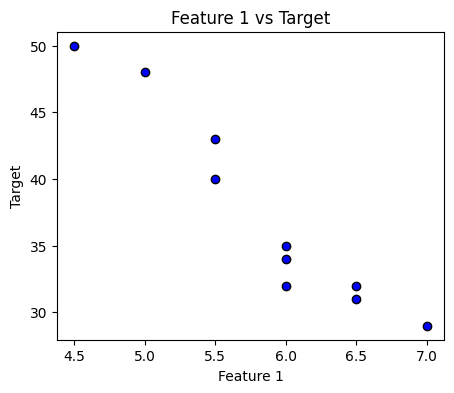

In [279]:
# Create a figure and two subplots
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

# Scatter plot for the first feature
axs.scatter(X, y, color='blue', edgecolors='k')
axs.set_xlabel('Feature 1')
axs.set_ylabel('Target')
axs.set_title('Feature 1 vs Target')

# Display the plots
plt.show()

Dựa trên hình ảnh trực quan hóa, ta có thể sử dụng mô hình hồi quy để mô hình hóa quan hệ giữa các feature 1 với target. Xem xét dạng của bài toán hồi quy tuyến tính như sau:

$$
y = \boldsymbol x^T\boldsymbol\theta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
trong đó $\boldsymbol x\in\mathbb{R}^D$ là biến phụ thuộc (đầu vào) và $y\in\mathbb{R}$ là các quan sát bị nhiễu. Vector tham số $\boldsymbol\theta\in\mathbb{R}^D$ tham số hóa hàm tuyến tính này.

Giả sử có tập huấn luyện $(\boldsymbol x_n, y_n)$, $n=1,\ldots, N$. Ta hình thức hóa các bộ dữ liệu đầu vào huấn luyện theo thứ tự $\mathcal X = \{\boldsymbol x_1, \ldots, \boldsymbol x_N\}$ và các mục tiêu huấn luyện tương ứng $\mathcal Y = \{y_1, \ldots, y_N\}$.

### Triển vọng cực đại

Phương pháp ước tính triển vọng cực đại của các tham số $\boldsymbol\theta$. Trong ước tính triển vọng cực đại, các tham số $\boldsymbol\theta^{\mathrm{ML}}$ cực đại hóa likelihood

$$
p(\mathcal Y | \mathcal X, \boldsymbol\theta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\theta)\,.
$$

Giải bài toán tối ưu, nghiệm thu được là:

$$
\boldsymbol\theta^{\text{ML}} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y\in\mathbb{R}^D\,,
$$
trong đó:
$$
\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^T\in\mathbb{R}^{N\times D}\,,\quad \boldsymbol y = [y_1, \ldots, y_N]^T \in\mathbb{R}^N\,.
$$

In [280]:
def MLE(X, y):
    """Hàm ước lượng triển vọng cực đại

    Parameters
    ----------
    X
        N x D ma trận dữ liệu huấn luyện đầu vào
    y
        N x 1 vector của mục tiêu huấn luyện/ quan sát huấn luyện

    Returns
    -------
        tham số triển vọng cực đại (D x 1)
    """
    # YOUR CODE HERE
    theta_ml = np.linalg.inv(X.T @ X) @ X.T @ y
    # raise NotImplementedError()
    return theta_ml

In [281]:
def predict_with_estimate(Xtest, theta):
    """Hàm dự đoán

    Parameters
    ----------
    Xtest
        K x D ma trận dữ liệu kiểm tra
    theta
        D x 1 vector tham số

    Returns
    -------
        kết quả dự đoán f(Xtest); K x 1 vector
    """
    # YOUR CODE HERE
    prediction = Xtest @ theta
    # raise NotImplementedError()
    return prediction 

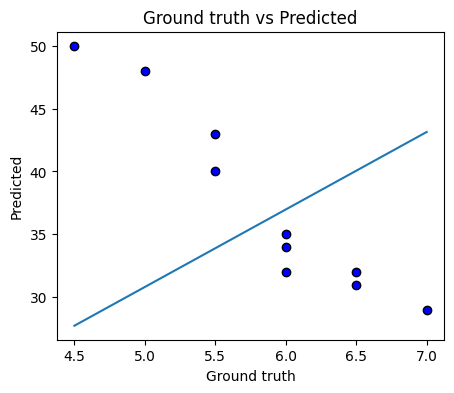

In [282]:
# Tính toán ước lượng triển vọng cực đại
theta_ml = MLE(X, y)

# dự đoán các giá trị hàm tại các điểm kiểm tra bằng bộ ước lượng triển vọng cực đại
mle_pred = predict_with_estimate(X, theta_ml)

# Trực quan
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.scatter(X, y, color='blue', edgecolors='k')
axs.plot(X, mle_pred)
axs.set_xlabel('Ground truth')
axs.set_ylabel('Predicted')
axs.set_title('Ground truth vs Predicted')

plt.show()

In [283]:
# Đánh giá RMSE
RMSE(y, mle_pred)

11.38335212244427

TODO: Bạn có nhận xét gì?

YOUR ANSWER HERE

* Nếu không thêm bias, mô hình không có khả năng bù đắp cho giá trị trung bình của dữ liệu, dẫn đến dự đoán không chính xác. 
* Mô hình bị giới hạn ở việc đi qua gốc tọa độ (0,0), khiến cho mô hình hóa dữ liệu trở nên kém linh hoạt hơn. Điều này làm tăng sai số dự đoán. 

Ta sẽ thêm một bias vào mô hình để nó linh hoạt hơn.

$$
y = \theta_0 + \boldsymbol x^T \boldsymbol\theta_1 + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)
$$

Định nghĩa:

$$\boldsymbol x_{\text{aug}} = \begin{bmatrix}1\\\boldsymbol x\end{bmatrix}$$

Ta viết lại phương trình mô hình hồi quy tuyến tính:

$$
y = \boldsymbol x_{\text{aug}}^T\boldsymbol\theta_{\text{aug}} + \epsilon\,,\quad \boldsymbol\theta_{\text{aug}} = \begin{bmatrix}
\theta_0\\
\boldsymbol\theta_1
\end{bmatrix}\,.
$$

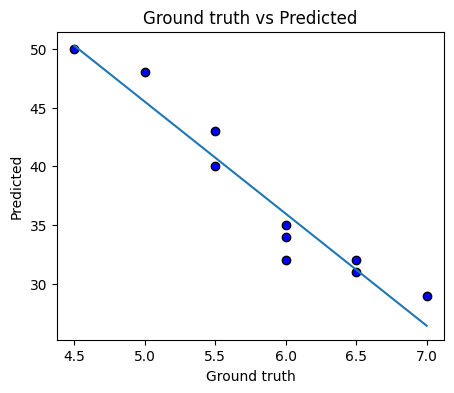

In [284]:
# Thêm bias vào data (cột đầu tiên full 1)
X_aug = np.hstack([np.ones((len(X),1)), X])

# Tính toán ước lượng triển vọng cực đại
theta_ml = MLE(X_aug, y)

# dự đoán các giá trị hàm tại các điểm kiểm tra bằng bộ ước lượng triển vọng cực đại
mle_pred = predict_with_estimate(X_aug, theta_ml)

# Trực quan
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.scatter(X, y, color='blue', edgecolors='k')
axs.plot(X, mle_pred)
axs.set_xlabel('Ground truth')
axs.set_ylabel('Predicted')
axs.set_title('Ground truth vs Predicted')

plt.show()


In [285]:
# Đánh giá RMSE
RMSE(y, mle_pred)

1.995018672215266

TODO: Bạn có nhận xét gì?

YOUR ANSWER HERE

* Sau khi thêm bias, mô hình có khả năng thích ứng tốt hơn với dữ liệu. 
* Bias giúp mô hình có thể di chuyển đường hồi quy ra khỏi gốc tọa độ, cho phép nó mô phỏng chính xác mối quan hệ giữa các biến. 
* Mô hình có độ chính xác cao hơn và sai số dự đoán thấp hơn.

### Phi tuyến hóa hồi quy tuyến tính 

Ta hoàn toàn có thể khớp các hàm phi tuyến tính trong đầu vào $\boldsymbol x$, miễn là các tham số $\boldsymbol\theta$ xuất hiện tuyến tính. Điều này có nghĩa là, chúng ta có thể học các hàm có dạng:

$$
f(\boldsymbol x, \boldsymbol\theta) = \sum_{k = 1}^K \theta_k \phi_k(\boldsymbol x)\,,
$$
trong đó các đặc trưng $\phi_k(\boldsymbol x)$ là các phép biến đổi (có thể phi tuyến tính) của các đầu vào $\boldsymbol x$.

Một trong những loại hàm thường hay sử dụng đó là hàm đa thức bậc $K$, ta viết

$$
\sum_{k=0}^K \theta_k x^k = \boldsymbol \phi(x)^T\boldsymbol\theta\,,\quad
\boldsymbol\phi(x)= 
\begin{bmatrix}
x^0\\
x^1\\
\vdots\\
x^K
\end{bmatrix}\in\mathbb{R}^{K+1}\,.
$$
Ở đây, $\boldsymbol\phi(x)$ là phép biến đổi đặc trưng phi tuyến tính của các đầu vào $x\in\mathbb{R}$.

Từ đó, tập huấn luyện sau khi biến đổi có dạng:
$$
\boldsymbol\Phi = \begin{bmatrix}
\boldsymbol\phi(x_1) & \boldsymbol\phi(x_2) & \cdots & \boldsymbol\phi(x_n)
\end{bmatrix}^T \in\mathbb{R}^{N\times K+1}
$$

In [286]:
def poly_features(X, K):
    """tính toán ma trận đặc trưng Phi (N x (K+1))

    Parameters
    ----------
    X
        đầu vào có kích thước N x 1
    k
        bậc của đa thức

    Returns
    -------
        tính toán ma trận đặc trưng Phi (N x (K+1))
    """
    # YOUR CODE HERE
    raise NotImplementedError()

Nghiệm tối ưu

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$

Nghiệm tối ưu (+tối ưu tính toán số học)

$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi + \kappa\boldsymbol I)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$

In [287]:
def nonlinearMLE(Phi, y):
    """Non-linear MLE

    Parameters
    ----------
    Phi
        ma trận đặc trưng cho dữ liệu đầu vào. Kích thước N x (K+1)
    y
       các mục tiêu huấn luyện. Kích thước N x 1

    Returns
    -------
        bộ ước lượng triển vọng cực đại theta_ml. Kích thước D x 1
    """
    
    kappa = 1e-08 # 'jitter' term; nhằm mục tiêu tối ưu tính toán số học
    
    # YOUR CODE HERE
    raise NotImplementedError()
    return theta_ml

In [288]:
k = 5 # Định nghĩa bậc đa thức mà ta muốn khớp

phiX = poly_features(X, k) # N x (K+1) ma trận đặc trưng

poly_theta_ml = nonlinearMLE(phiX, y) # bộ ước lượng triển vọng cực đại

mle_pred = predict_with_estimate(phiX, poly_theta_ml)

# Trực quan
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

axs.scatter(X, y, color='blue', edgecolors='k')
axs.plot(X, mle_pred)
axs.set_xlabel('Ground truth')
axs.set_ylabel('Predicted')
axs.set_title('Ground truth vs Predicted')

plt.show()

NotImplementedError: 

TODO: Bạn có nhận xét gì?

YOUR ANSWER HERE